# Stock Price Predictor but playing with different parameters

In [205]:
# Import dependencies

# Machine Learning
# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Concatenate, Input, Reshape
from keras.regularizers import l2
from keras import layers, Model, Sequential, callbacks
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Data manipulation
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' #This line is necessary on macbook s.t. models compile
from datetime import datetime, timedelta

plt.style.use('seaborn-colorblind')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Training example specific
import talib as ta

import yfinance as yf

import datacleaning as dc

In [4]:
df_nasdaq = pd.read_csv('nasdaq_clean_with_indicators.csv', index_col='DATE')

df_spy = pd.read_csv('spy_clean_with_indicators.csv', index_col = 'Date')

In [246]:
# Define a list of tickers from different sectors
tickers = [
# Index Futures
    "ES=F",  # E-mini S&P 500 futures
    
    # Tech
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "GOOGL", # Alphabet (Google)
    # "AMZN",  # Amazon
    # "META",  # Meta Platforms (Facebook)
    "NVDA",  # NVIDIA
    "TSLA",  # Tesla
    
    # Financial
    "JPM",   # JPMorgan Chase
    # "BAC",   # Bank of America
    "GS",    # Goldman Sachs
    "V",     # Visa
    "MA",    # Mastercard
    "BRK-B", # Berkshire Hathaway
    # "WFC",   # Wells Fargo
    
    # Healthcare
    "JNJ",   # Johnson & Johnson
    "PFE",   # Pfizer
    "UNH",   # UnitedHealth Group
    # "ABBV",  # AbbVie
    # "MRK",   # Merck
    
    # Industrial/Energy
    "XOM",   # Exxon Mobil
    "CVX",   # Chevron
    # "CAT",   # Caterpillar
    # "BA",    # Boeing
    "GE",    # General Electric
    
    # Consumer
    "PG",    # Procter & Gamble
    "KO",    # Coca-Cola
    "WMT",   # Walmart
    "MCD",   # McDonald's
    # "NKE",   # Nike
    
    # Telecom
    "VZ",    # Verizon
    "T",     # AT&T
    
    # Commodities-related
    "GLD",   # SPDR Gold Shares ETF
    # "USO",   # United States Oil Fund
    
    # Bonds/Fixed Income
    # "TLT",   # iShares 20+ Year Treasury Bond ETF
    # "AGG",   # iShares Core U.S. Aggregate Bond ETF

    # Indexes
    "SPY",   # SPDR S&P 500 ETF
    "QQQ",   # Invesco QQQ (tracks NASDAQ-100)
    # "IWM",   # iShares Russell 2000 ETF (small caps)
    "DIA",   # SPDR Dow Jones Industrial Average ETF
    "VTI",   # Vanguard Total Stock Market ETF
    
    # Sector ETFs
    # "XLF",   # Financial Select Sector SPDR Fund
    # "XLK",   # Technology Select Sector SPDR Fund
    # "XLE",   # Energy Select Sector SPDR Fund
    # "XLV",   # Health Care Select Sector SPDR Fund
    # "XLY",   # Consumer Discretionary Select Sector SPDR Fund
]

In [327]:
tickers = [
    # Tech
    "AAPL", "MSFT", "GOOGL", "AMZN", "META",
    # Financial
    "JPM", "BAC", "GS", "V", "MA",
    # Healthcare
    "JNJ", "PFE", "UNH", "ABBV", "MRK",
    # Industrial/Energy
    "XOM", "CVX", "CAT", "BA", "GE"
]

In [328]:
# Set the time period for data download
end_date = '2024-01-01'
start_date = '2019-01-01'

# Create a dictionary to store dataframes
stock_data = {}

# Download data for each ticker
for ticker in tickers:
    try:
        # Download the data
        print(f"Downloading data for {ticker}...")
        data = yf.download(ticker, start=start_date, end=end_date)

        data.columns = data.columns.get_level_values(0)
        
        # Store in dictionary using ticker as key
        stock_data[ticker] = data
        
        
        print(f"Successfully downloaded data for {ticker}, shape: {data.shape}")
    except Exception as e:
        print(f"Error downloading {ticker}: {e}")

print(f"Downloaded data for {len(stock_data)} stocks")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for AAPL, shape: (1258, 5)
Successfully downloaded data for MSFT, shape: (1258, 5)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for GOOGL, shape: (1258, 5)
Successfully downloaded data for AMZN, shape: (1258, 5)
Successfully downloaded data for META, shape: (1258, 5)
Successfully downloaded data for JPM, shape: (1258, 5)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for BAC, shape: (1258, 5)
Successfully downloaded data for GS, shape: (1258, 5)
Successfully downloaded data for V, shape: (1258, 5)
Successfully downloaded data for MA, shape: (1258, 5)
Successfully downloaded data for JNJ, shape: (1258, 5)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for PFE, shape: (1258, 5)
Successfully downloaded data for UNH, shape: (1258, 5)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ABBV, shape: (1258, 5)
Successfully downloaded data for MRK, shape: (1258, 5)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XOM, shape: (1258, 5)
Successfully downloaded data for CVX, shape: (1258, 5)


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for CAT, shape: (1258, 5)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for BA, shape: (1258, 5)
Successfully downloaded data for GE, shape: (1258, 5)
Downloaded data for 20 stocks


In [329]:
def combined_data(stock_data, feature_columns = ['Close', 'Volume']):
    combined_data = []
    stock_identifiers = []

    for ticker, df in stock_data.items():
        temp_df = df.copy()

        temp_df['ticker'] = ticker

        # stock_identifiers.extend([ticker] * len(temp_df))

        combined_data.append(temp_df)

    all_data = pd.concat(combined_data, axis = 0)

    all_data = all_data.filter(['Close', 'Volume', 'ticker'])

    return all_data
    

In [330]:
combined_df = combined_data(stock_data)

In [339]:
combined_df.head()

Price,Close,Volume,ticker,SMA_10,SMA_20,SMA_30,EMA_10,EMA_20,EMA_30,RSI,bb_high,bb_low,bb_mid,MACD,MACD_signal,MACD_hist
Date,,,,,,,,,,,,,,,,
2019-02-13,40.765533,89960800,AAPL,40.725024,38.985370,37.991968,40.346933,39.431308,38.882470,57.936925,42.742321,35.228418,38.985370,1.072186,0.892408,0.179778
2019-02-14,40.914055,87342800,AAPL,40.846491,39.183253,38.100198,40.450046,39.572522,39.013540,58.463813,42.908662,35.457843,39.183253,1.054647,0.924856,0.129791
2019-02-15,40.823029,98507200,AAPL,40.956948,39.365613,38.330457,40.517861,39.691618,39.130281,57.995148,43.036780,35.694445,39.365613,1.021625,0.944210,0.077416
2019-02-19,40.945198,75891200,AAPL,40.966801,39.542632,38.516528,40.595559,39.811007,39.247373,58.465536,43.159564,35.925701,39.542632,0.993857,0.954139,0.039718
2019-02-20,41.208687,104457600,AAPL,40.933118,39.774806,38.714006,40.707037,39.944119,39.373909,59.495303,43.187828,36.361783,39.774806,0.981794,0.959670,0.022124


In [340]:
combined_df.shape

(25131, 16)

In [333]:
def sma(df, window):
    df[f'SMA_{window}'] = df['Close'].rolling(window = window).mean()
    return df

def ema(df, span):
    df[f'EMA_{span}'] = df['Close'].ewm(span = span, adjust = False).mean()
    return df

def rsi(df, window):
    df['RSI'] = ta.RSI(df['Close'], timeperiod = window)
    return df

def bbands(df, window):
    high, mid, low = ta.BBANDS(df['Close'], timeperiod = window)

    df['bb_high'] = high
    df['bb_low'] = low
    df['bb_mid'] = mid
    
    return df

def MACD(df, fast, slow, signal):
    ema_fast = df['Close'].ewm(span = fast, adjust = False).mean()
    ema_slow = df['Close'].ewm(span = slow, adjust = False).mean()

    macd = ema_fast - ema_slow

    signal_line = macd.ewm(span = signal, adjust = False).mean()

    macd_hist = macd - signal_line

    df['MACD'] = macd
    df['MACD_signal'] = signal_line
    df['MACD_hist'] = macd_hist

    return df

def add_target(df):
    df['target'] = df['Close'].shift(-1)

    df = df.dropna()
    
    return df

In [334]:
combined_df = sma(combined_df, 10)
combined_df = sma(combined_df, 20)
combined_df = sma(combined_df, 30)

combined_df = ema(combined_df, 10)
combined_df = ema(combined_df, 20)
combined_df = ema(combined_df, 30)

combined_df = rsi(combined_df, 20)

combined_df = bbands(combined_df,20)

combined_df = MACD(combined_df, fast = 12, slow = 26, signal = 9)

combined_df = combined_df.dropna()

In [335]:
msft = combined_df[combined_df['ticker'] == 'MSFT']

In [336]:
msft.shape

(1258, 16)

In [341]:
def create_sequences(df, sequence_length, target_col = 'Close'):
    features = df.drop(['ticker'], axis = 1)

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(features)

    X, y = [],[]

    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i+sequence_length])

        target_idx = features.columns.get_loc(target_col)

        y.append(scaled_data[i + sequence_length, target_idx])

    return np.array(X), np.array(y), scaler

In [342]:
X_train, y_train, feature_scaler = create_sequences(combined_df, 20)

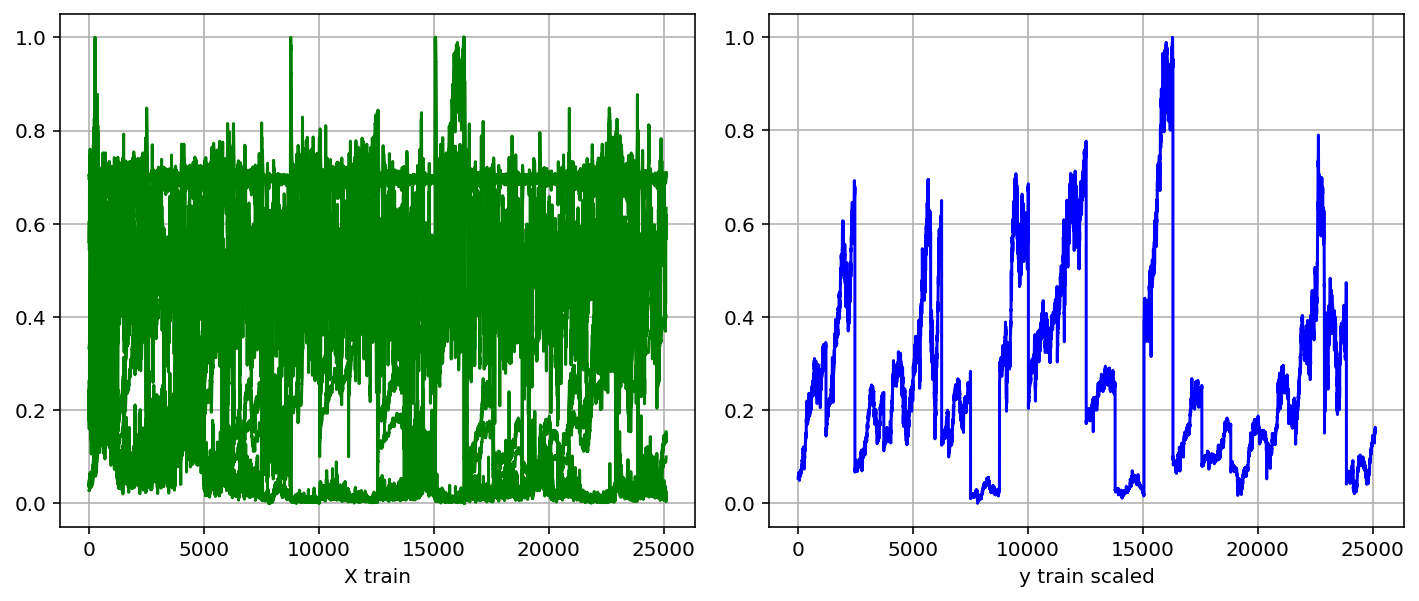

In [353]:
import importlib
import datacleaning as dc
importlib.reload(dc)
dc.plot_train_test_spy(X_train, y_train)

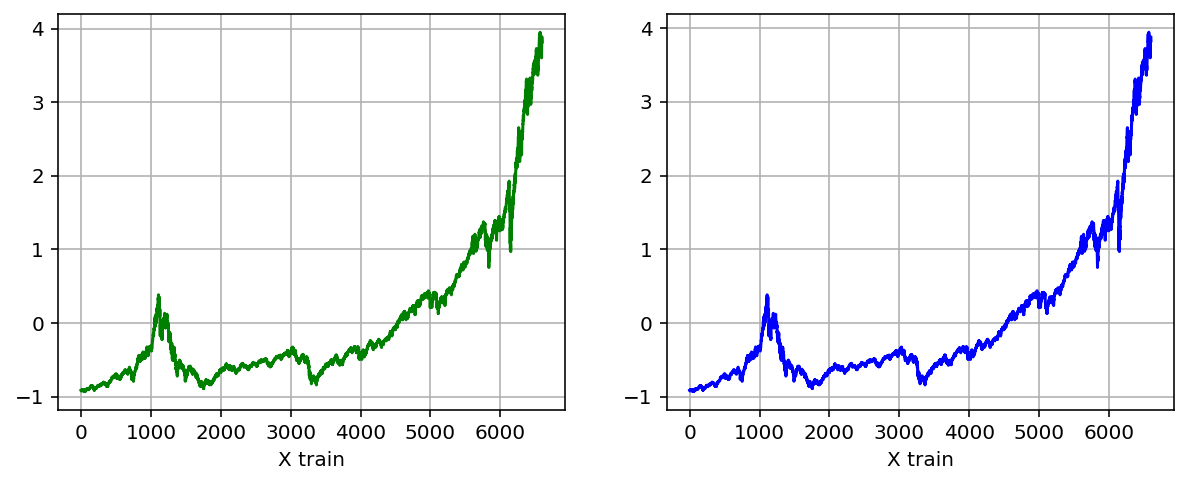

In [724]:
import importlib
import datacleaning as dc
importlib.reload(dc)

dc.plot_train_test_nasdaq(X_nasdaq_scaled, y_nasdaq_scaled)

# Prediction Modelling

In [727]:
print('='*30)
print("Shape of S&P TRAIN arrays")
print(X_train.shape)
print(y_train.shape)
print('='*30)

Shape of S&P TRAIN arrays
(5112, 15, 5)
(5112, 1)
Shape of NASDAQ TRAIN arrays
(6584, 15, 10)
(6584, 1)


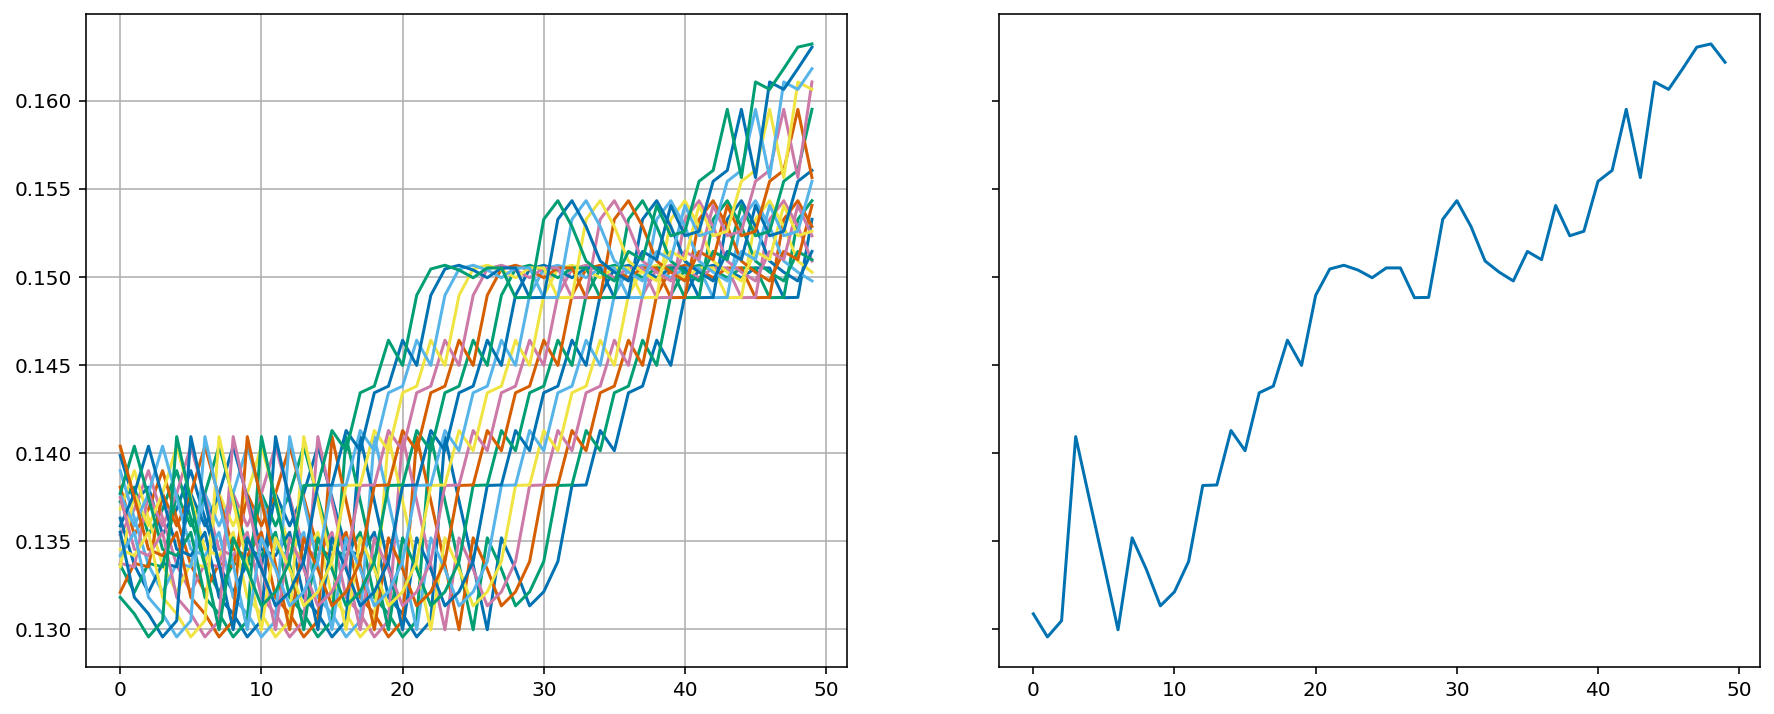

In [357]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = 'row', figsize  = (15,6))

ax1.plot(X_train[-50:,:,0])
ax1.grid(True)
ax2.plot(y_train[-50:])

In [362]:
gru = Sequential([
    GRU(192, 
        return_sequences = True, 
        input_shape = (X_train.shape[1],X_train.shape[2]),
        kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    GRU(96, return_sequences = True,
        kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    GRU(48, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(1, activation = 'linear')
])

In [363]:
gru.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_61 (GRU)                (None, 20, 192)           120384    
                                                                 
 batch_normalization_12 (Bat  (None, 20, 192)          768       
 chNormalization)                                                
                                                                 
 dropout_31 (Dropout)        (None, 20, 192)           0         
                                                                 
 gru_62 (GRU)                (None, 20, 96)            83520     
                                                                 
 batch_normalization_13 (Bat  (None, 20, 96)           384       
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 20, 96)          

In [203]:
def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MSE(y_true, y_pred)
    mae = tf.keras.losses.MAE(y_true, y_pred)
    return 0.3 * mae + 0.7 * mse  # Adjust weights as needed

In [364]:
learning_rate = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, clipnorm= 1.0)

gru.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)

In [206]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# Create callbacks
# 1. Reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce LR by half when plateau detected
    patience=7,          # Wait 5 epochs of no improvement before reducing
    min_lr=5e-8,         # Don't go below this learning rate
    verbose=1            # Print message when reducing LR
)

# 2. Early stopping with patience of 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=10,                  # Stop after 10 epochs of no improvement
    restore_best_weights=True,    # Restore model to best point when stopped
    verbose=1                     # Print message when early stopping
)

# 3. Model checkpoint to save best model
checkpoint = ModelCheckpoint(
    'best_gru_model.keras',       # File to save model to
    monitor='val_loss',           # Monitor validation loss
    save_best_only=True,          # Only save if better than previous best
    verbose=1                     # Print message when saving
)

# Apply gradient clipping (add this before compiling your model)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.0)
# When compiling your model, use this optimizer instead of the default

# Train on first dataset with modified callbacks
history = gru.fit(
    X_train, y_train, 
    validation_split=0.15,    # Add validation split for monitoring
    epochs=100,               # Set higher max epochs (early stopping will prevent overfitting)
    batch_size=32,
    callbacks=[lr_scheduler, early_stopping, checkpoint],
    verbose=1
)

# # Reset learning rate for the optimizer before training on second dataset
# initial_learning_rate = 5e-4  # Starting with recommended learning rate
# tf.keras.backend.set_value(gru.optimizer.lr, initial_learning_rate)

# # Train on second dataset with the same strategy
# history_2 = gru.fit(
#     X_train_nasdaq, y_train_nasdaq,
#     validation_split=0.15,    # Add validation split for monitoring
#     epochs=50,               # Set higher max epochs (early stopping will prevent overfitting)
#     batch_size=32,
#     callbacks=[lr_scheduler, early_stopping, checkpoint],
#     verbose=1
# )

Epoch 1/100
1536/1536 [==============================] - ETA: 0s - loss: 0.6213 - mse: 0.0011 - mean_absolute_error: 0.0063
Epoch 1: val_loss improved from inf to 0.52771, saving model to best_gru_model.keras
1536/1536 [==============================] - 120s 72ms/step - loss: 0.6213 - mse: 0.0011 - mean_absolute_error: 0.0063 - val_loss: 0.5277 - val_mse: 6.7104e-06 - val_mean_absolute_error: 9.1983e-04 - lr: 1.0000e-05
Epoch 2/100
1536/1536 [==============================] - ETA: 0s - loss: 0.4543 - mse: 2.4220e-04 - mean_absolute_error: 0.0023
Epoch 2: val_loss improved from 0.52771 to 0.38695, saving model to best_gru_model.keras
1536/1536 [==============================] - 110s 72ms/step - loss: 0.4543 - mse: 2.4220e-04 - mean_absolute_error: 0.0023 - val_loss: 0.3869 - val_mse: 7.0974e-06 - val_mean_absolute_error: 0.0011 - lr: 1.0000e-05
Epoch 3/100
1536/1536 [==============================] - ETA: 0s - loss: 0.3332 - mse: 2.3129e-04 - mean_absolute_error: 0.0022
Epoch 3: val_los

In [365]:
history = gru.fit(X_train, y_train,
                  epochs = 30,
                  batch_size = 64,
                  verbose = 1)

Epoch 1/30
393/393 [==============================] - 32s 62ms/step - loss: 0.6272 - mae: 0.4579
Epoch 2/30
393/393 [==============================] - 24s 62ms/step - loss: 0.2267 - mae: 0.2361
Epoch 3/30
393/393 [==============================] - 24s 62ms/step - loss: 0.1069 - mae: 0.1248
Epoch 4/30
393/393 [==============================] - 24s 62ms/step - loss: 0.0585 - mae: 0.0682
Epoch 5/30
393/393 [==============================] - 25s 62ms/step - loss: 0.0345 - mae: 0.0425
Epoch 6/30
393/393 [==============================] - 24s 62ms/step - loss: 0.0211 - mae: 0.0344
Epoch 7/30
393/393 [==============================] - 24s 62ms/step - loss: 0.0130 - mae: 0.0312
Epoch 8/30
393/393 [==============================] - 24s 61ms/step - loss: 0.0083 - mae: 0.0314
Epoch 9/30
393/393 [==============================] - 25s 63ms/step - loss: 0.0053 - mae: 0.0300
Epoch 10/30
393/393 [==============================] - 24s 61ms/step - loss: 0.0037 - mae: 0.0306
Epoch 11/30
393/393 [========

In [733]:
### Only use if you want to save the model

gru.save("gru model 2024-06 l2 reg")

In [41]:
gru = tf.keras.models.load_model('gru model 2024-06 l2 reg')

In [33]:
gru = tf.keras.models.load_model('gru model 2023-11')

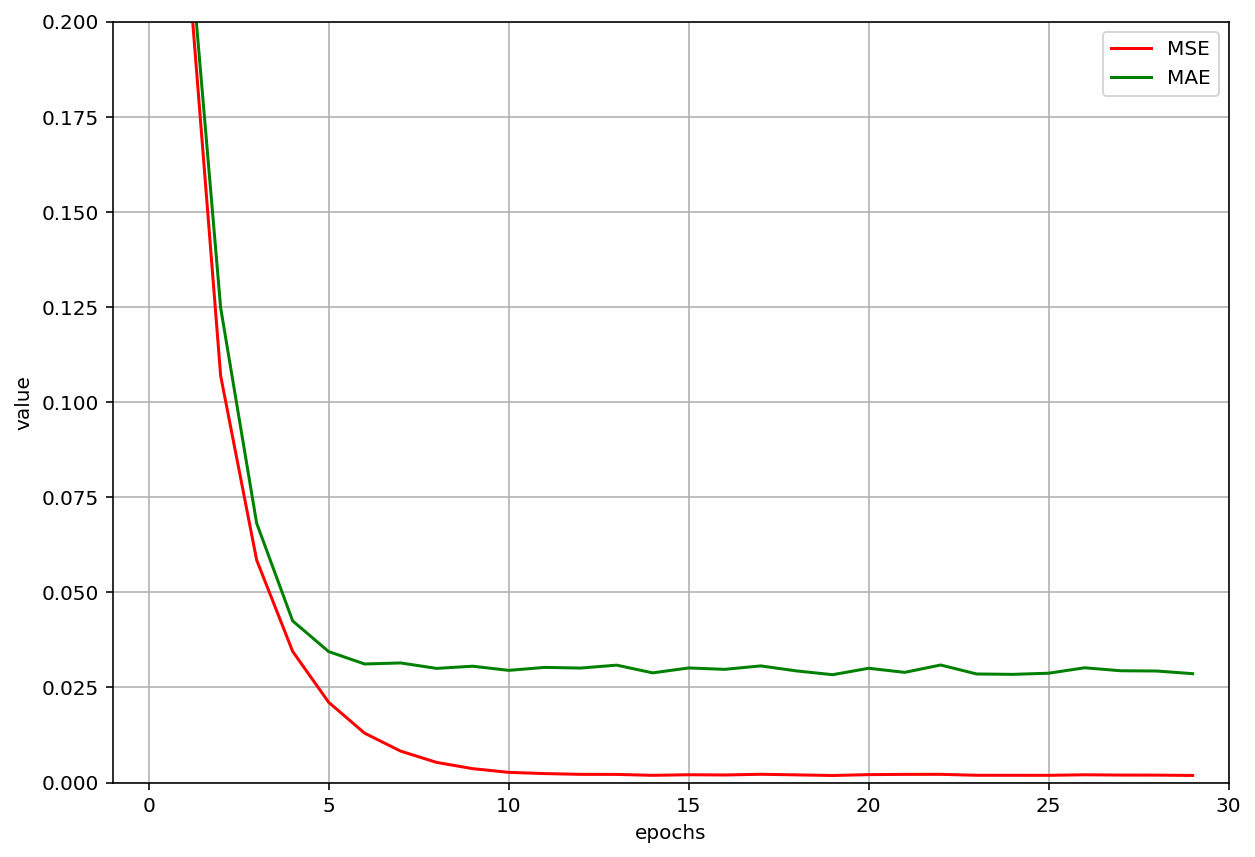

In [366]:
plt.figure(figsize = (10,7))
plt.plot(history.history["loss"], c = 'r', label = 'MSE')
plt.plot(history.history['mae'], c = 'g', label = 'MAE')
# plt.plot(history.history['mse'], c = 'b', label = 'validation loss')

plt.xlabel('epochs')
plt.ylabel('value')
plt.ylim(0,0.2)
plt.xlim(-1,30)
plt.grid(True)
plt.legend()
plt.show()

KeyError: 'mean_absolute_error'

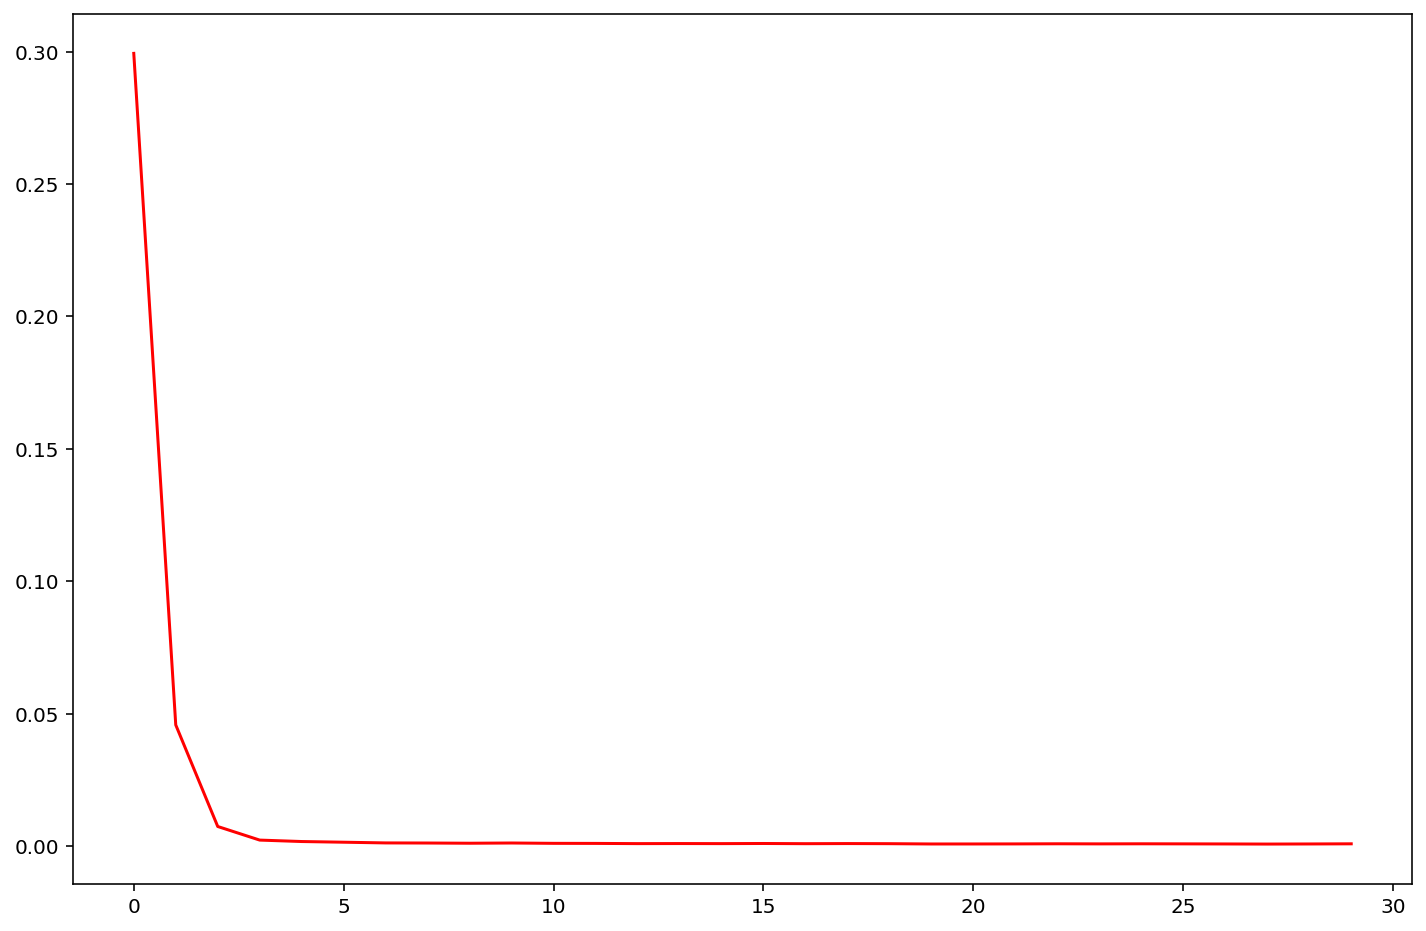

In [315]:
plt.figure(figsize=(12, 8))

# Training metrics
plt.plot(history.history["loss"], c='r', linestyle='-', label='Train MSE')
plt.plot(history.history['mean_absolute_error'], c='g', linestyle='-', label='Train MAE')
plt.plot(history.history['mse'], c='b', linestyle='-', label='Train MSE (Alt)')  # Optional: duplicate of 'loss'?

# Validation metrics
plt.plot(history.history["val_loss"], c='r', linestyle='--', label='Val MSE')
plt.plot(history.history['val_mean_absolute_error'], c='g', linestyle='--', label='Val MAE')
plt.plot(history.history['val_mse'], c='b', linestyle='--', label='Val MSE (Alt)')

# Labels and display settings
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training vs Validation Metrics')
plt.ylim(0, 0.02)
plt.xlim(-1, 100)
plt.grid(True)
plt.legend()
plt.show()

In [367]:
import yfinance as yf

new_data = yf.download("ES=F", start="2024-01-01", end="2025-03-31")

new_data.columns = new_data.columns.get_level_values(0)

[*********************100%***********************]  1 of 1 completed


In [368]:
new_data = sma(new_data, 10)
new_data = sma(new_data, 20)
new_data = sma(new_data, 30)

new_data = ema(new_data, 10)
new_data = ema(new_data, 20)
new_data = ema(new_data, 30)

new_data = rsi(new_data, 20)

new_data = bbands(new_data,20)

new_data = MACD(new_data, fast = 12, slow = 26, signal = 9)

new_data = new_data.dropna()

new_data = new_data.drop(['High', 'Low', 'Open'], axis = 1)

In [369]:
new_data.tail()

Price,Close,Volume,SMA_10,SMA_20,SMA_30,EMA_10,EMA_20,EMA_30,RSI,bb_high,bb_low,bb_mid,MACD,MACD_signal,MACD_hist
Date,,,,,,,,,,,,,,,
2025-03-24,5815.50,1404629,5642.17998,5742.32749,5861.451660,5693.069504,5750.747267,5804.144771,49.038573,6013.730643,5470.924338,5742.32749,-83.134794,-97.085448,13.950654
2025-03-25,5826.50,1078548,5667.12998,5735.15249,5852.709993,5717.329595,5757.961813,5805.587044,49.521610,5989.128467,5481.176514,5735.15249,-67.027541,-91.073867,24.046326
2025-03-26,5759.50,1483959,5682.60498,5724.58999,5841.618327,5724.996941,5758.108307,5802.613687,46.684537,5954.969794,5494.210187,5724.58999,-58.988781,-84.656849,25.668069
2025-03-27,5739.25,1575855,5703.77998,5717.73999,5830.501660,5727.588406,5756.312278,5798.525707,45.848874,5937.580831,5497.899149,5717.73999,-53.633754,-78.452230,24.818476
2025-03-28,5623.00,1910914,5702.07998,5700.72749,5813.426660,5708.572332,5743.615870,5787.201468,41.373544,5892.853477,5508.601503,5700.72749,-58.100514,-74.381887,16.281373


In [370]:
new_data.shape

(283, 15)

In [371]:
# Fit transform on test sets
scaled_test = feature_scaler.transform(new_data)

# Creating the test data
X_test, y_test = [], []

length_test = scaled_test.shape[0]

sequence_length = 20

for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    target_idx = new_data.columns.get_loc('Close')
    y_test.append(scaled_test[i+sequence_length, target_idx])

X_test, y_test = np.array(X_test), np.array(y_test)

In [372]:
loss, accuracy = gru.evaluate(X_test, y_test)

print('')
print('-'*35)
print('Test set Loss:', loss)
print('Test set MAE:', accuracy)
print('-'*35)

9/9 [==============================] - 1s 15ms/step - loss: 79.0926 - mae: 8.8732

-----------------------------------
Test set Loss: 79.09262084960938
Test set MAE: 8.873196601867676
-----------------------------------


In [373]:
# Make a prediction on the test set
y_pred_on_test = gru.predict(X_test)
y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

9/9 [==============================] - 2s 14ms/step


In [374]:
def inverse_transform_predictions(predictions, y_test, scaler, features, target_col='Close'):
    """
    Inverse transform scaled predictions and actual values back to original scale
    
    Args:
        predictions: Model predictions (scaled)
        y_test: Actual target values (scaled)
        scaler: The fitted MinMaxScaler used for normalization
        features: Original feature DataFrame to get column ordering
        target_col: Target column name (default: 'Close')
        
    Returns:
        actual_prices: Inverse-transformed actual prices
        predicted_prices: Inverse-transformed predicted prices
    """
    # Get the position of the target column
    target_idx = features.columns.get_loc(target_col)

    if len(predictions.shape) > 1 and predictions.shape[1] == 1:
        predictions = predictions.flatten()
    
    if len(y_test.shape) > 1 and y_test.shape[1] == 1:
        y_test = y_test.flatten()
    
    # Create dummy arrays for inverse transform
    # We need to create full feature vectors for inverse_transform to work correctly
    dummy_array_actual = np.zeros((len(y_test), features.shape[1]))
    dummy_array_pred = np.zeros((len(predictions), features.shape[1]))
    
    # Put the target values in the correct column position
    dummy_array_actual[:, target_idx] = y_test
    dummy_array_pred[:, target_idx] = predictions
    
    # Inverse transform to get original scale
    actual_full = scaler.inverse_transform(dummy_array_actual)
    predicted_full = scaler.inverse_transform(dummy_array_pred)
    
    # Extract just the target column values
    actual_prices = actual_full[:, target_idx]
    predicted_prices = predicted_full[:, target_idx]
    
    return actual_prices, predicted_prices

In [375]:
actual_prices, predicted_prices = inverse_transform_predictions(y_pred_on_test, y_test, feature_scaler, new_data)

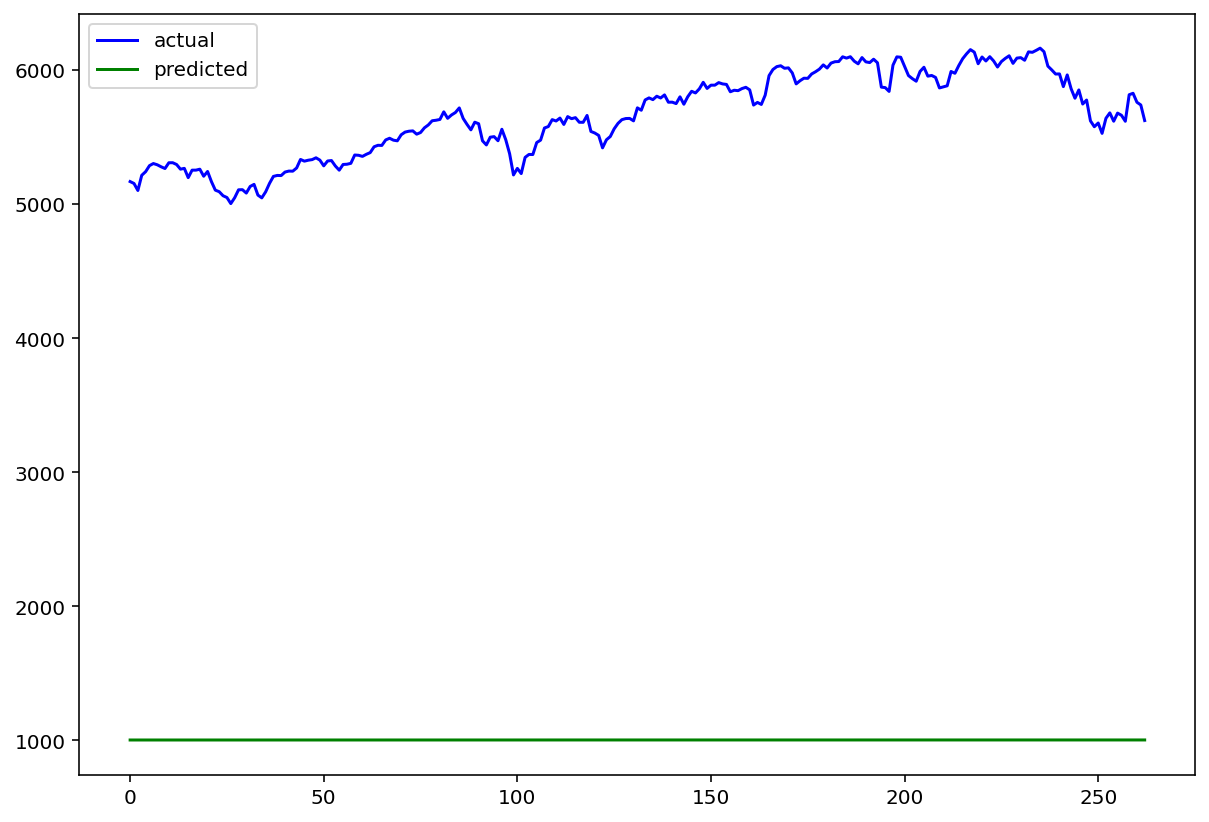

In [376]:
plt.figure(figsize = (10,7))
plt.plot(actual_prices, label = "actual", c = "blue")
plt.plot(predicted_prices, label = "predicted", c = "g")
plt.legend()
plt.show()

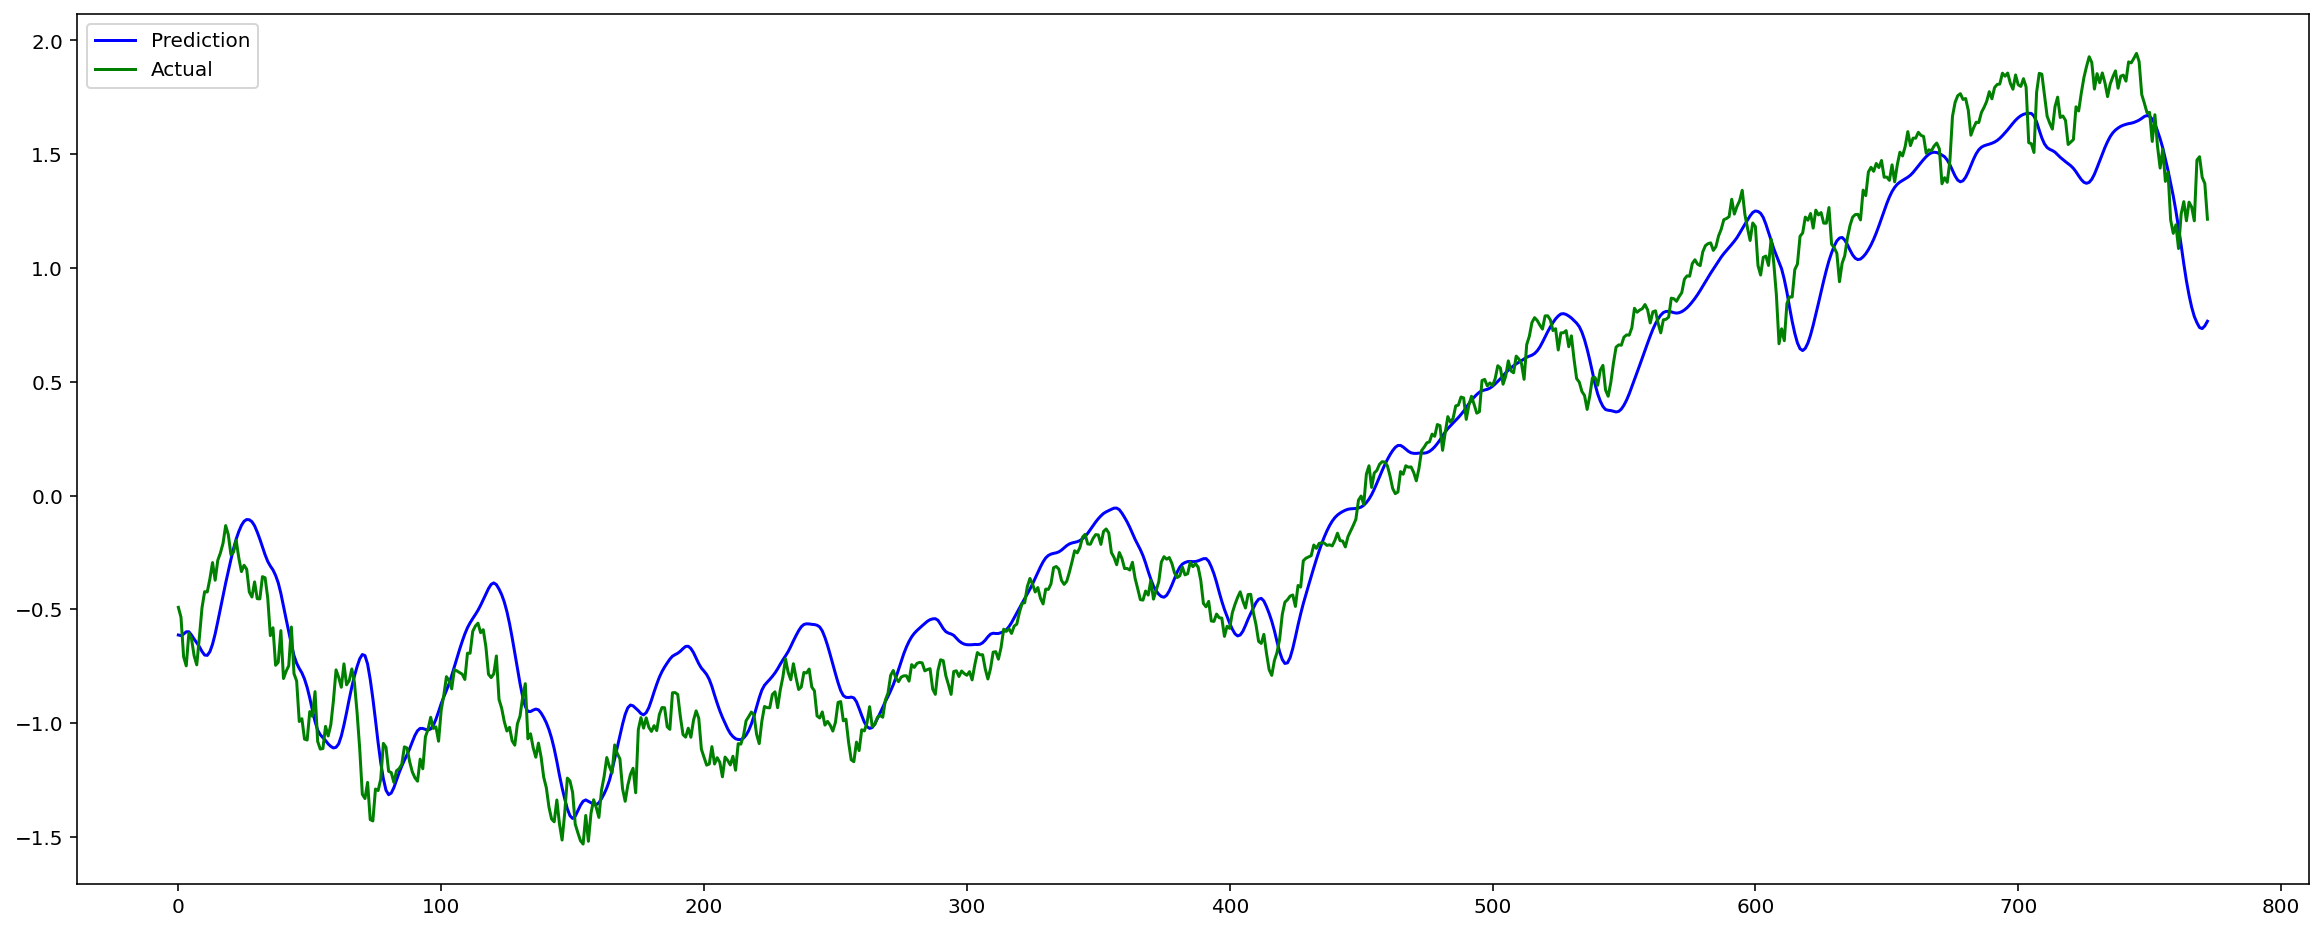

In [569]:
plt.figure(figsize = (20,8))
plt.plot(y_pred_on_test, label = "Prediction", c = "blue")
plt.plot(y_test, label = "Actual", c = "g")
plt.legend()
plt.show()

In [341]:
### Save this model as it's quite good

gru.save('20231023 - Test loss 0.02.h5')

In [41]:
gru = tf.keras.models.load_model('20231023 - Test loss 0.02.h5')

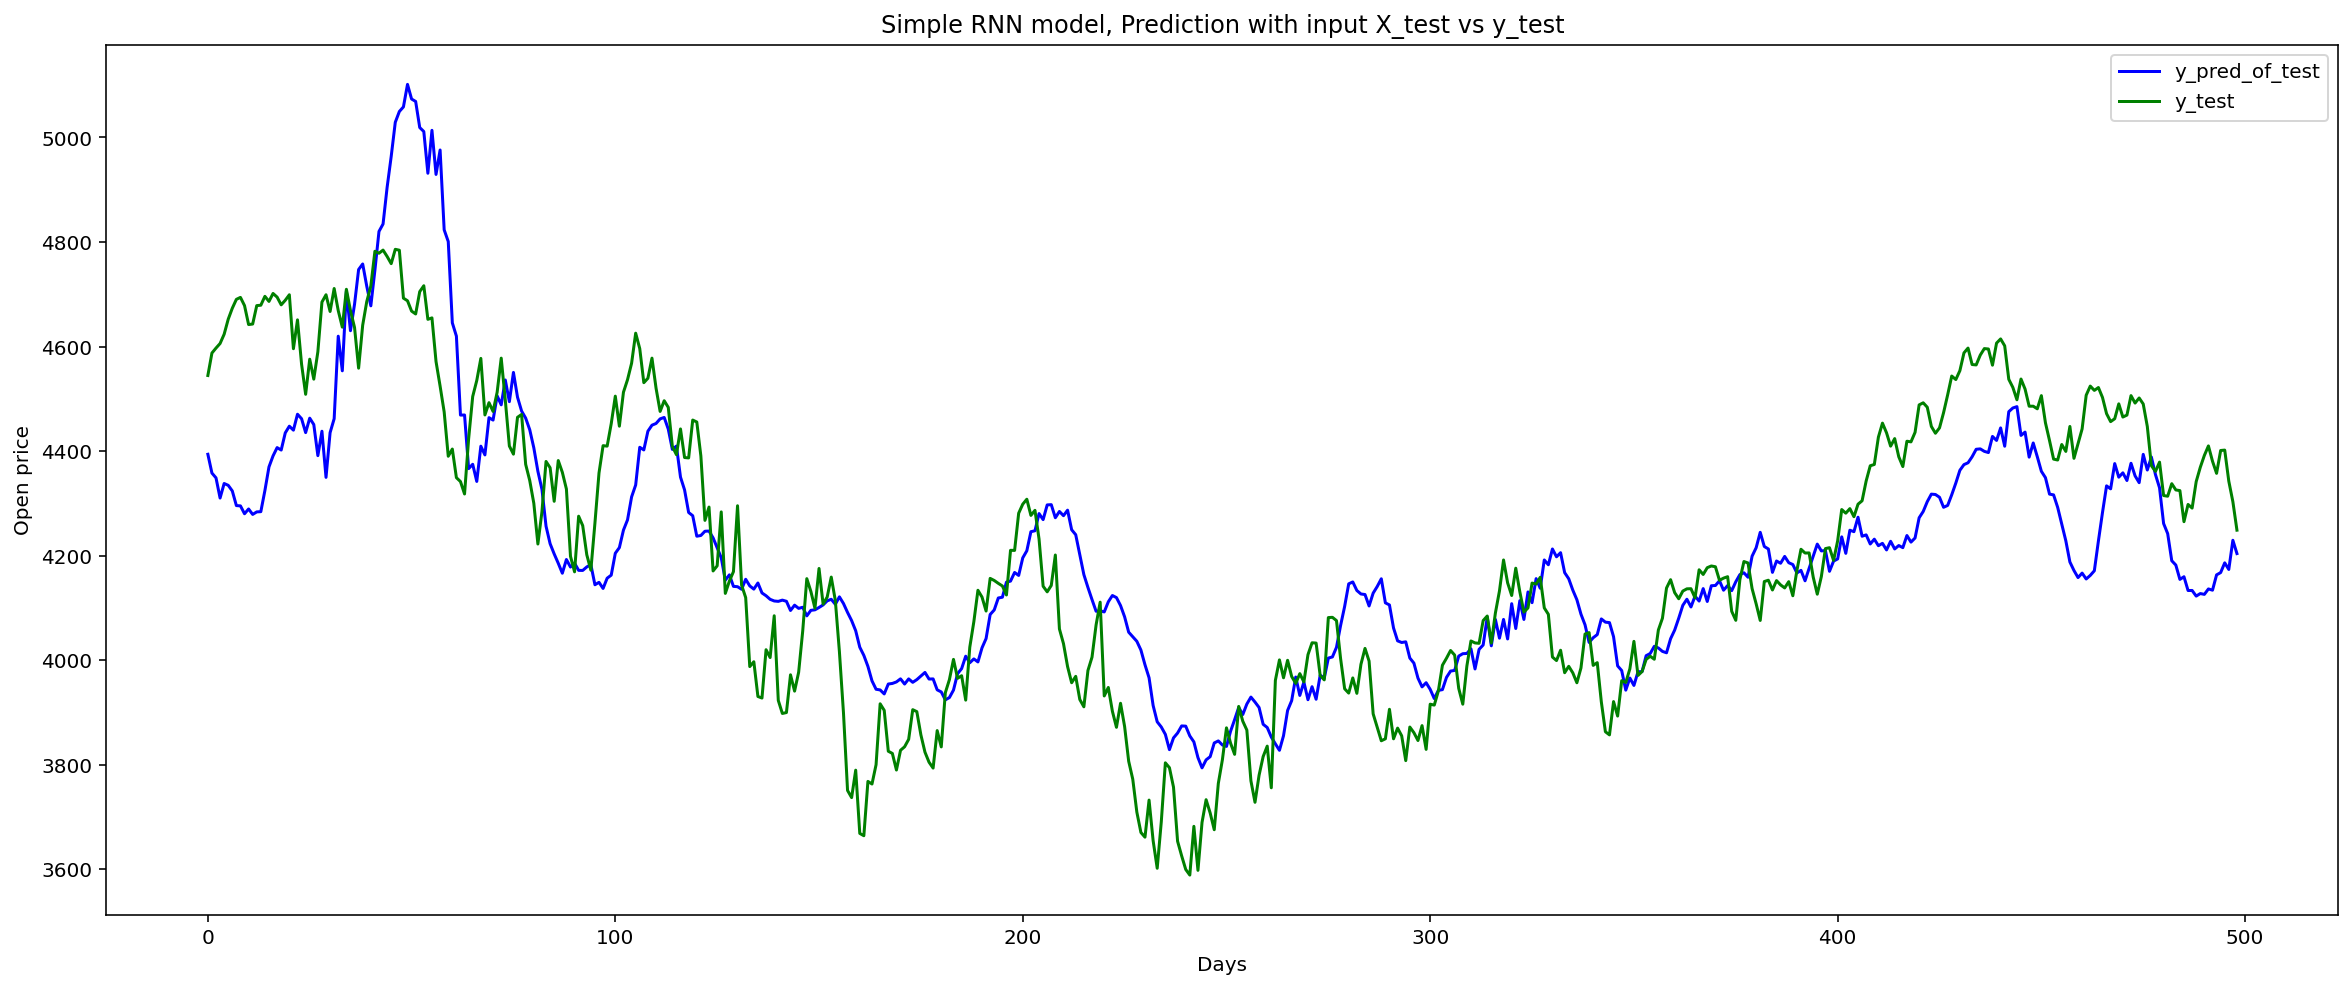

In [230]:
plt.figure(figsize = (20,8))
plt.plot(y_test_pred_unscaled[-500: -1], label = "y_pred_of_test", c = "blue")
plt.plot(y_test_unscaled[-500: -1], label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

## Actual prediction making

In [114]:
def get_new_values(ticker, start_date):
    """
    For the current use case, use the ticker ^GSPC
    """
    
    todays_date = datetime.today().strftime('%Y-%m-%d')
    
    new_dataframe = yf.download(ticker, start = start_date, end = todays_date)
    
    return new_dataframe


def add_values(new_dataframe, dataframe):
    
    new_dataframe = new_dataframe[['Close', 'Open']]
    new_dataframe = new_dataframe.rename(columns = {'Close' : 'close', 'Open': 'open'})
    
    concatenated_dataframe = pd.concat([dataframe, new_dataframe], axis = 0, join = 'outer')
    
    return concatenated_dataframe


def reshape_arrays(df, time_step):
    df = df.drop(['target'], axis = 1)

    X = df.iloc[- time_step - 1:-1]

    X = X.to_numpy()

    X = scaler_features.transform(X)

    X = X.reshape(1,time_step,10)

    return X


def open_clean_data(df):

    # Set Date column to datetime format, and set as index
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y', errors = 'coerce')
        df = df.set_index('Date')
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y', errors = 'coerce')
        df = df.set_index('date')
    elif 'DATE' in df.columns:
        df['DATE'] = pd.to_datetime(df['DATE'], format = '%d/%m/%Y', errors = 'coerce')
        df = df.set_index('DATE')
    
    # Clean data and rename remaining columns to make typing easier
    if 'Price' in df.columns:
        df = df.drop(df[df["Price"]==0].index)
    
    if 'Close' in df.columns:
        df = df.drop(df[df['Close'] == '.'].index)

    if 'High' in df.columns:
        df = df.drop(['High'], axis = 1)

    if 'Low' in df.columns:
        df = df.drop(['Low'], axis = 1)

    if 'Vol.' in df.columns:
        df = df.drop(['Vol.'], axis = 1)

    if 'Change %' in df.columns:
        df = df.drop(['Change %'], axis = 1)
    
    if 'Adj Close' in df.columns:
        df = df.drop(['Adj Close'], axis = 1)

    if 'Volume' in df.columns:
        df = df.drop(['Volume'], axis = 1)    

    if 'Price' in df.columns:
        df = df.rename(columns={'Price': 'close'})
    elif 'Close' in df.columns:
        df = df.rename(columns={'Close': 'close'})
    
    # Assuming that every element in column is same type
    if isinstance(df['close'].iloc[0], str):
        df['close'] = df['close'].str.replace(',','')
        df['close'] = df['close'].astype(float)
    
    df = technical_indicators(df)
    
    # We want to use data from day d to predict close of day d+1
    # Shift close data down and assign to 'target' col
    df['target'] = df['close'].shift(-1)

    # df['pct change'] = ((df['close'] - df['close'].shift(1))/df['close'].shift(1)) * 100

    # df = df.dropna()
    
    return df

In [231]:
new_data = get_new_values('ES=F', '2023-01-01')

[*********************100%***********************]  1 of 1 completed


In [80]:
fresh_data_1 = {'Close': 5641.00}

In [46]:
fresh_data_2 = {'Close': 4270.25}

In [250]:
fresh_data_1 = pd.DataFrame(fresh_data_1, index=['2024-08-21'])

In [438]:
fresh_data_2 = pd.DataFrame(fresh_data_2, index=['2023-10-24'])

In [252]:
new_data = new_data.append(fresh_data_1)

/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_746/4058603128.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(fresh_data_1)


In [440]:

new_data = new_data.append(fresh_data_2)

/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_4548/531779635.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(fresh_data_2)


In [232]:
new_data.columns = new_data.columns.get_level_values(0)

new_data = clean_data(new_data)

In [206]:
new_data = new_data.drop(new_data.index[-1])

In [233]:
new_data.tail()

,close,SMA30,SMA50,SMA70,EMA30,EMA50,EMA70,rsi,bb_high,bb_low,target
Date,,,,,,,,,,,
2025-03-24,5815.50,5861.451660,5933.190996,5950.279422,5804.144771,5863.750897,5883.591468,51.487625,6309.061721,5557.320271,5826.50
2025-03-25,5826.50,5852.709993,5932.395996,5946.475851,5805.587044,5862.290077,5881.983258,52.102234,6308.997143,5555.794849,5759.50
2025-03-26,5759.50,5841.618327,5930.095996,5942.172280,5802.613686,5858.259094,5878.533025,48.104627,6309.477796,5550.714196,5739.25
2025-03-27,5739.25,5830.501660,5927.235996,5937.654422,5798.525707,5853.592071,5874.609559,46.932559,6310.156965,5544.315028,5602.50
2025-03-28,5602.50,5812.743327,5919.505996,5930.825851,5785.878887,5843.745323,5866.944501,39.868105,6312.597017,5526.414975,NaN


In [234]:
X = reshape_arrays(new_data, time_step)

In [235]:
X.shape

(1, 30, 10)

In [236]:
predicted = gru.predict(X)

1/1 [==============================] - 0s 47ms/step


In [237]:
predicted_unscaled = scaler_target.inverse_transform(predicted)

In [238]:
predicted_unscaled

array([[5780.181]], dtype=float32)

In [131]:
ESMini_prediction = np.append(ESMini_prediction, predicted_unscaled)

In [298]:
ESMini_prediction[-5:]

array([5490.677 , 5570.066 , 5636.1694, 5689.23  , 5725.5186],
      dtype=float32)

In [299]:
final_el_list = new_data['close'].iloc[-365:]

std_dev = np.std(final_el_list)

print(std_dev)

466.34734552899715


# Prediction Clean Up

In [239]:
new_data_ESMini = new_data.drop(['target'], axis = 1)

ESMini_array = new_data_ESMini.to_numpy()

ESMini_scaled = scaler_features.transform(ESMini_array)

In [240]:
ESMini_test = []

for i in range(time_step, new_data.shape[0]):
    ESMini_test.append(ESMini_scaled[i - time_step : i, :])

ESMini_array = np.array(ESMini_test)

In [241]:
ESMini_prediction = gru.predict(ESMini_array)
ESMini_prediction = np.reshape(ESMini_prediction, (-1,1))

ESMini_prediction = scaler_target.inverse_transform(ESMini_prediction)

15/15 [==============================] - 0s 9ms/step


In [242]:
print(type(ESMini_prediction))

<class 'numpy.ndarray'>


In [243]:
ESMini_prediction_list = np.reshape(ESMini_prediction, (-1))

In [244]:
# calc difference between new_data shape and prediction list
diff = new_data.shape[0] - ESMini_prediction_list.shape[0]

# create list of 0's of length diff
set_vals = [0 for _ in range(diff)]

# set prediction list to type list
ESMini_prediction_list = ESMini_prediction_list.tolist()

In [245]:
ESMini_prediction_list = set_vals + ESMini_prediction_list

In [246]:
prediction_dates = new_data.index

prediction_df = pd.DataFrame({
    'prediction': ESMini_prediction_list
}, index = prediction_dates)

In [247]:
result_df = new_data.merge(prediction_df, left_index = True, right_index = True, how = 'left')

In [248]:
result_df.tail(20)

,close,SMA30,SMA50,SMA70,EMA30,EMA50,EMA70,rsi,bb_high,bb_low,target,prediction
Date,,,,,,,,,,,,
2025-03-03,5860.750000,6062.216667,6019.415195,6025.464425,6026.209789,6017.711117,5993.913944,36.308727,6200.925157,5837.905234,5789.500000,5857.258301
2025-03-04,5789.500000,6054.083333,6017.760195,6023.332282,6010.938190,6008.761661,5988.155804,32.455871,6205.991920,5829.528470,5851.250000,5812.623535
2025-03-05,5851.250000,6046.316667,6017.410195,6022.096568,6000.635726,6002.584733,5984.299303,38.542583,6206.810356,5828.010035,5746.250000,5755.107910
2025-03-06,5746.250000,6033.841667,6015.530000,6018.892997,5984.223744,5992.532391,5977.593689,33.083242,6213.595460,5817.464540,5776.000000,5718.334473
2025-03-07,5776.000000,6021.308333,6010.330000,6015.878711,5970.789954,5984.040924,5971.914993,35.855546,6219.323336,5801.336664,5620.750000,5677.737793
2025-03-10,5620.750000,6004.225000,6000.785000,6010.367997,5948.206731,5969.794222,5962.023022,29.083980,6234.965935,5766.604065,5577.000000,5646.935547
2025-03-11,5577.000000,5988.566667,5990.420000,6003.778711,5924.257910,5954.390527,5951.177303,27.507408,6251.311902,5729.528098,5604.750000,5599.375488
2025-03-12,5604.750000,5972.158333,5981.975000,5997.917997,5903.644496,5940.679133,5941.418787,30.095816,6264.059336,5699.890664,5527.500000,5539.648438
2025-03-13,5527.500000,5954.158333,5973.350000,5990.432282,5879.377109,5924.476030,5929.759103,27.185764,6282.792499,5663.907501,5640.000000,5489.973145


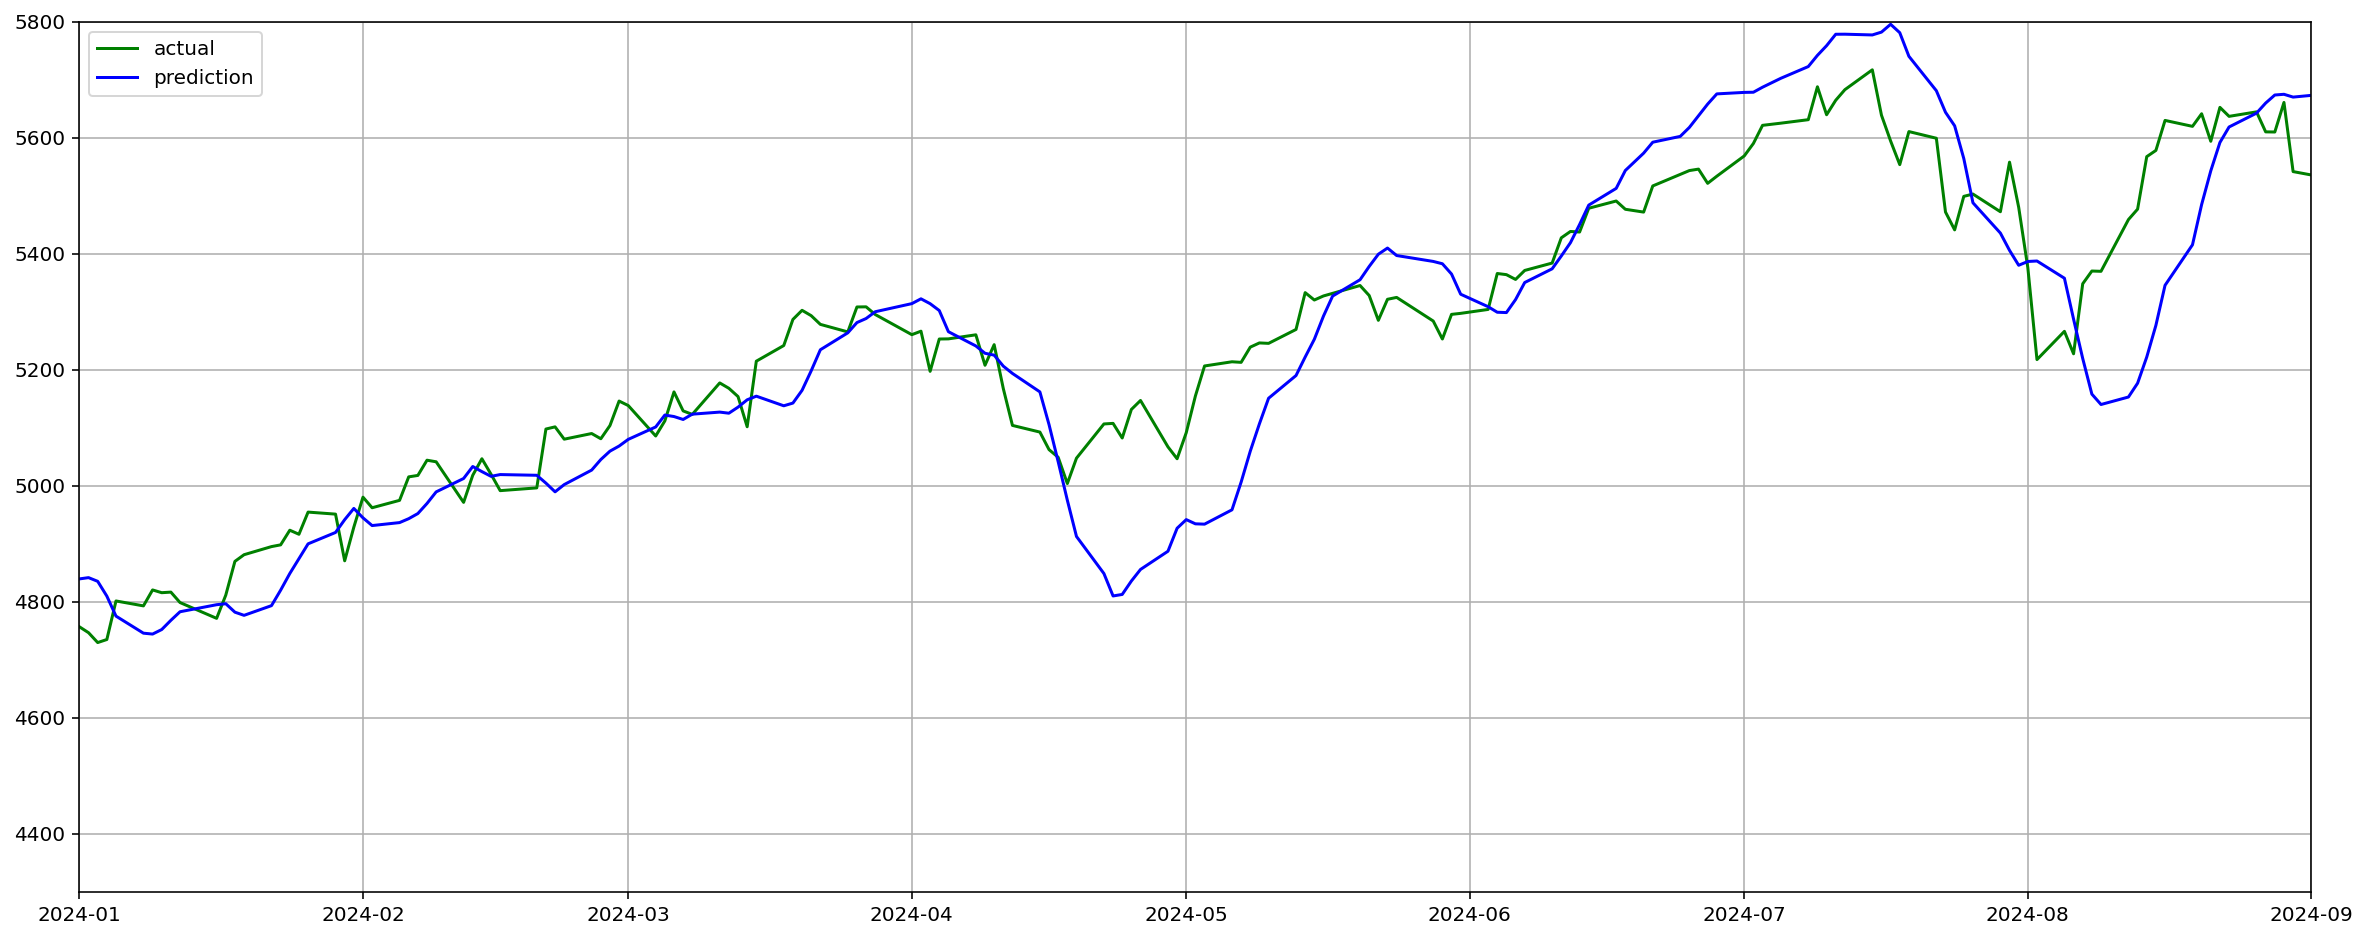

In [249]:
plt.figure(figsize = (20,8))
plt.plot(result_df['target'], label='actual', c="g")
plt.plot(result_df['prediction'], label='prediction', c="b")
plt.xlim(pd.Timestamp('2024-01-01'), pd.Timestamp('2024-09-01'))
plt.ylim(4300,5800)
plt.grid()
plt.legend()
plt.show()

In [250]:
testing_df = result_df.copy()

In [251]:
testing_df['signal'] = np.where(testing_df['prediction'] > testing_df['prediction'].shift(1), 1, 0)

In [252]:
testing_df.tail()

,close,SMA30,SMA50,SMA70,EMA30,EMA50,EMA70,rsi,bb_high,bb_low,target,prediction,signal
Date,,,,,,,,,,,,,
2025-03-24,5815.50,5861.451660,5933.190996,5950.279422,5804.144771,5863.750897,5883.591468,51.487625,6309.061721,5557.320271,5826.50,5566.241211,1
2025-03-25,5826.50,5852.709993,5932.395996,5946.475851,5805.587044,5862.290077,5881.983258,52.102234,6308.997143,5555.794849,5759.50,5620.431641,1
2025-03-26,5759.50,5841.618327,5930.095996,5942.172280,5802.613686,5858.259094,5878.533025,48.104627,6309.477796,5550.714196,5739.25,5692.006348,1
2025-03-27,5739.25,5830.501660,5927.235996,5937.654422,5798.525707,5853.592071,5874.609559,46.932559,6310.156965,5544.315028,5602.50,5747.244629,1
2025-03-28,5602.50,5812.743327,5919.505996,5930.825851,5785.878887,5843.745323,5866.944501,39.868105,6312.597017,5526.414975,NaN,5780.181152,1


In [253]:
test_data = get_new_values('ES=F', '2023-01-01')

[*********************100%***********************]  1 of 1 completed


In [254]:
test_data.columns = test_data.columns.get_level_values(0)

test_data = pd.DataFrame(test_data['Open'])

test_data.head()

,Open
Date,
2023-01-03,3895.00
2023-01-04,3842.75
2023-01-05,3871.00
2023-01-06,3833.00
2023-01-09,3918.50


In [255]:
test_data = testing_df.merge(test_data, left_index = True, right_index = True, how = 'left')

test_data = test_data.iloc[diff:]

In [256]:
test_data.head(30)

,close,SMA30,SMA50,SMA70,EMA30,EMA50,EMA70,rsi,bb_high,bb_low,target,prediction,signal,Open
Date,,,,,,,,,,,,,,
2023-05-25,4159.750000,4152.216667,4116.661001,4080.318572,4142.842204,4118.602346,4095.197225,51.983613,4254.111171,3979.210831,4213.250000,4088.251709,1,4157.00
2023-05-26,4213.250000,4153.866667,4121.716001,4081.104286,4147.384642,4122.314019,4098.522655,58.487766,4254.327431,3989.104571,4215.000000,4071.216553,0,4157.00
2023-05-30,4215.000000,4155.141667,4126.875000,4082.750715,4151.746923,4125.948763,4101.803707,58.684908,4253.390977,4000.359023,4190.500000,4076.390137,1,4239.75
2023-05-31,4190.500000,4155.491667,4131.025000,4084.222144,4154.247122,4128.480184,4104.302195,54.763797,4251.877193,4010.172807,4228.000000,4091.382324,1,4213.00
2023-06-01,4228.000000,4157.141667,4134.870000,4087.397144,4159.005372,4132.382922,4107.786640,59.251687,4255.585626,4014.154374,4288.000000,4098.277344,1,4188.50
2023-06-02,4288.000000,4161.658333,4141.220000,4091.525715,4167.327606,4138.485552,4112.863072,65.200539,4260.070647,4022.369353,4281.000000,4109.845703,1,4231.75
2023-06-05,4281.000000,4165.800000,4147.280000,4095.272144,4174.661309,4144.074354,4117.599324,64.026149,4263.083266,4031.476734,4289.750000,4136.428223,1,4288.00
2023-06-06,4289.750000,4170.141667,4153.050000,4099.757858,4182.086386,4149.787125,4122.448639,64.877754,4267.919752,4038.180248,4274.250000,4163.823242,1,4279.75
2023-06-07,4274.250000,4176.175000,4158.390000,4103.847144,4188.032425,4154.668022,4126.724733,62.074436,4270.441513,4046.338487,4298.250000,4188.705078,1,4292.25


In [257]:
# If prediction for that day is 1, then calculate the difference between open and close for that day

test_data['correct up guess'] = np.where((test_data['signal'] == 1) & (test_data['close'] > test_data['Open']), 1, 0)

test_data['correct down guess'] = np.where((test_data['signal'] == 0) & (test_data['close'] < test_data['Open']), 1, 0)

test_data['incorrect up guess'] = np.where((test_data['signal'] == 1) & (test_data['close'] < test_data['Open']), 1, 0)

test_data['incorrect down guess'] = np.where((test_data['signal'] == 0) & (test_data['close'] > test_data['Open']), 1, 0)

test_data['profit'] = np.where(test_data['signal']==1, test_data['close'] - test_data['Open'], 0)

In [258]:
test_data.head(10)

,close,SMA30,SMA50,SMA70,EMA30,EMA50,EMA70,rsi,bb_high,bb_low,target,prediction,signal,Open,correct up guess,correct down guess,incorrect up guess,incorrect down guess,profit
Date,,,,,,,,,,,,,,,,,,,
2025-03-17,5680.250000,5925.950000,5962.710000,5978.935854,5852.082881,5904.180103,5914.798371,39.826735,6295.414905,5630.005095,5618.000000,5431.127930,0,5626.75,0,0,0,1,0.000000
2025-03-18,5618.000000,5912.475000,5955.280000,5972.071568,5836.980760,5892.957354,5906.437854,36.862191,6301.575129,5608.984871,5678.500000,5454.880371,1,5680.00,0,0,1,0,-62.000000
2025-03-19,5678.500000,5899.658333,5948.440000,5966.210854,5826.756195,5884.547262,5900.017069,41.425623,6302.730073,5594.149927,5662.500000,5480.092773,1,5618.50,1,0,0,0,60.000000
2025-03-20,5662.500000,5885.525000,5942.605000,5959.975140,5816.159021,5875.839526,5893.326448,40.590075,6305.817749,5579.392251,5617.799805,5515.122070,1,5680.00,0,0,1,0,-17.500000
2025-03-21,5617.799805,5869.251660,5935.775996,5953.575851,5803.361652,5865.720321,5885.565134,38.267819,6310.148362,5561.403630,5815.500000,5548.194824,1,5664.00,0,0,1,0,-46.200195
2025-03-24,5815.500000,5861.451660,5933.190996,5950.279422,5804.144771,5863.750897,5883.591468,51.487625,6309.061721,5557.320271,5826.500000,5566.241211,1,5740.00,1,0,0,0,75.500000
2025-03-25,5826.500000,5852.709993,5932.395996,5946.475851,5805.587044,5862.290077,5881.983258,52.102234,6308.997143,5555.794849,5759.500000,5620.431641,1,5813.00,1,0,0,0,13.500000
2025-03-26,5759.500000,5841.618327,5930.095996,5942.172280,5802.613686,5858.259094,5878.533025,48.104627,6309.477796,5550.714196,5739.250000,5692.006348,1,5831.00,0,0,1,0,-71.500000
2025-03-27,5739.250000,5830.501660,5927.235996,5937.654422,5798.525707,5853.592071,5874.609559,46.932559,6310.156965,5544.315028,5602.500000,5747.244629,1,5737.25,1,0,0,0,2.000000


In [259]:
test_data = test_data.drop(axis = 1, columns = ['SMA30', 'SMA50', 'SMA70', 'EMA30', 'EMA50', 'EMA70', 'rsi', 'bb_high', 'bb_low',])

In [260]:
correct_up_guesses = test_data['correct up guess'].sum()

correct_down_guesses = test_data['correct down guess'].sum()

incorrect_up_guesses = test_data['incorrect up guess'].sum()

incorrect_down_guesses = test_data['incorrect down guess'].sum()

print(f"""
    Number of correct up guesses: {correct_up_guesses}
    Number of incorrect up guesses: {incorrect_up_guesses}
    Number of correct down guesses: {correct_down_guesses}
    Number of incorrect down guesses: {incorrect_down_guesses}
""")


    Number of correct up guesses: 159
    Number of incorrect up guesses: 125
    Number of correct down guesses: 80
    Number of incorrect down guesses: 98



In [178]:
print(test_data['profit'].sum())

925.39013671875


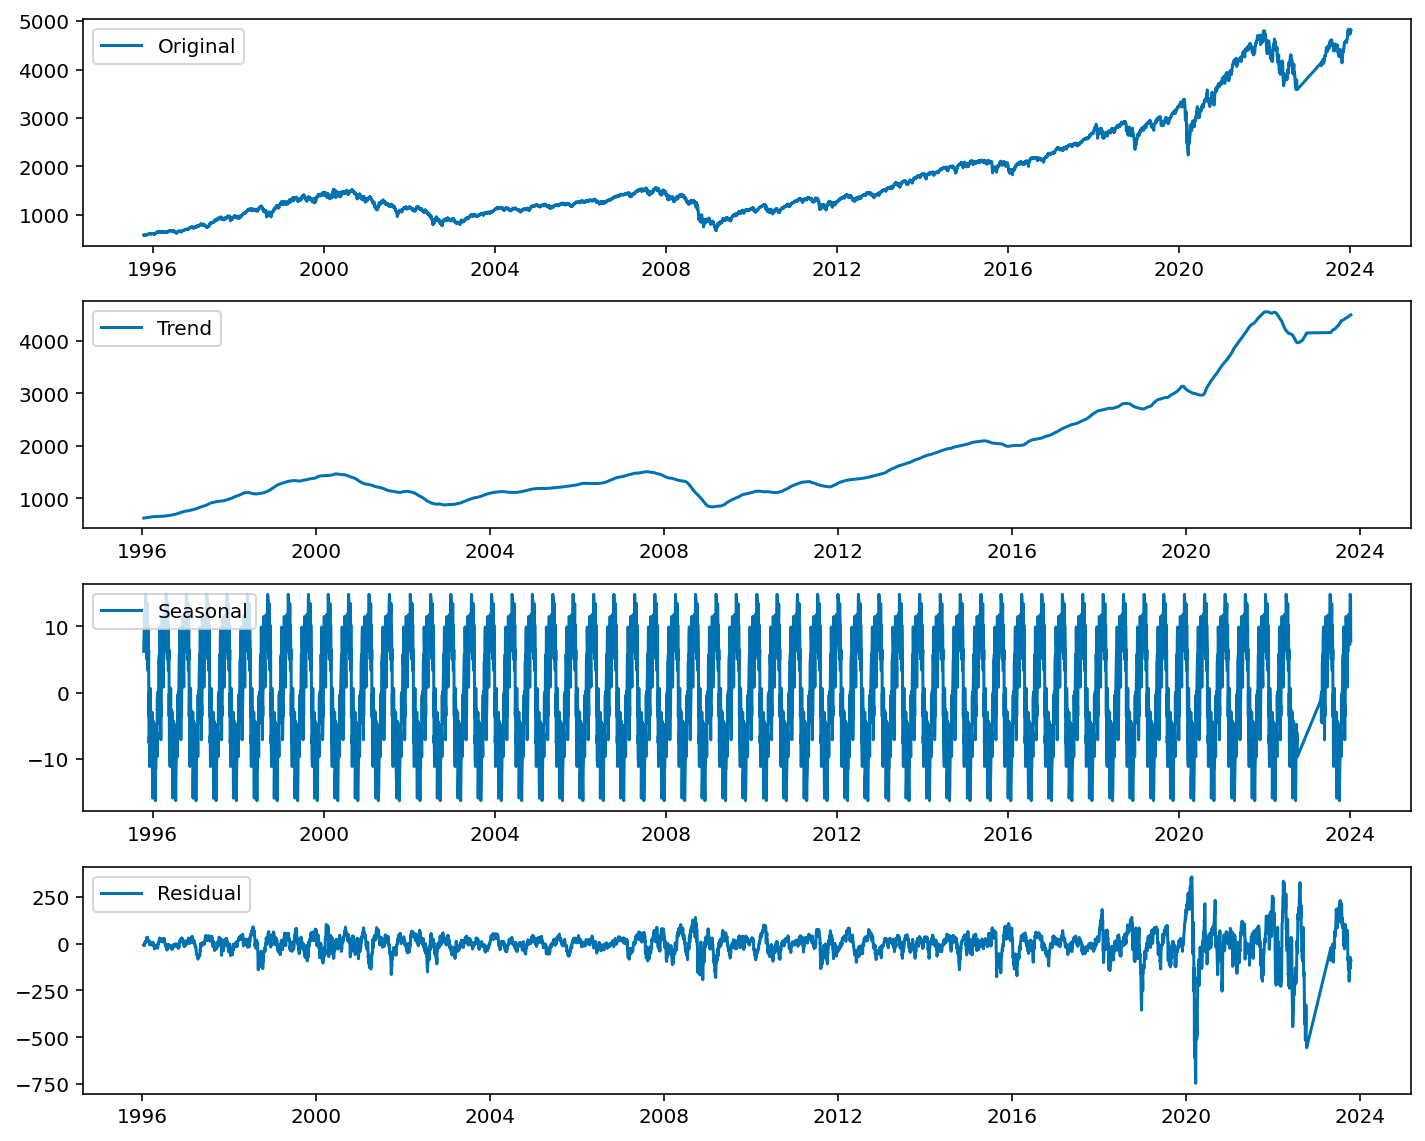

In [179]:
### Checking for seasonal correlations using seasonal decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
result = seasonal_decompose(df['close'], model='additive', period = 120)

# Plot the decomposition
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(df['close'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [113]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose?

Signature:
seasonal_decompose(
    x,
    model='additive',
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
)
Docstring:
Seasonal decomposition using moving averages.

Parameters
----------
x : array_like
    Time series. If 2d, individual series are in columns. x must contain 2
    complete cycles.
model : {"additive", "multiplicative"}, optional
    Type of seasonal component. Abbreviations are accepted.
filt : array_like, optional
    The filter coefficients for filtering out the seasonal component.
    The concrete moving average method used in filtering is determined by
    two_sided.
period : int, optional
    Period of the series. Must be used if x is not a pandas object or if
    the index of x does not have  a frequency. Overrides default
    periodicity of x if x is a pandas object with a timeseries index.
two_sided : bool, optional
    The moving average method used in filtering.
    If True (default), a centered moving average is computed using 